# Analyser et visualiser une enquête sur les couleurs

Nous disposons d'un fichier csv, contenant les réponses données par des panélistes sur l'utilisation des couleurs en français. Nous souhaitons observer l'utilisation de "marron" et "brun". "marron" prend-t-il le pas sur "brun"?

Nous allons pour ce faire :
- partir du fichier csv contenant les réponses des personnes interrogées : "brun_marron.csv"
- utiliser des bibliothèques python (pandas, matplot, wordcloud).

In [1]:
# import des biblio python utiles
import pandas as pd
import numpy as np
import csv
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
# import du fichier csv
csv_file="brun_marron.csv"
# créer l'objet "data", contenant l'ensemble des données
data = pd.read_csv(csv_file,delimiter='\t')
# enlever les lignes où tout est "Na"
data=data.dropna(how = 'all')
# modifier l'index par défaut, mettre comme index l'id des panelistes
data=data.set_index("CASE")

Vérifions que l'import s'est bien passé, que notre objet data contient bien nos données :

- regarder les premières lignes du tableau

In [3]:
# .head : méthode pour afficher les 5 premières lignes de l'objet
data.head()

,SERIAL,REF,QUESTNNR,MODE,STARTED,PI06,PI01,PI02,PI03,PI04_01,...,LASTDATA,FINISHED,Q_VIEWER,LASTPAGE,MAXPAGE,MISSING,MISSREL,TIME_RSI,DEG_TIME,commentaires
CASE,,,,,,,,,,,,,,,,,,,,,
52,NaN,NaN,base,interview,18/02/2021 08:26:32,1,3.0,1.0,4.0,Espagnol,...,18/02/2021 08:27:38,0,0,3,3,0,0,0.76,0,NaN
54,NaN,NaN,base,interview,18/02/2021 08:29:26,1,3.0,1.0,4.0,Espagnol,...,18/02/2021 08:45:31,1,0,18,18,23,13,1.11,19,NaN
55,NaN,NaN,base,interview,18/02/2021 08:30:42,1,4.0,2.0,1.0,NaN,...,18/02/2021 08:40:40,1,0,18,18,23,12,1.25,18,NaN
61,NaN,NaN,base,interview,18/02/2021 08:57:24,1,4.0,2.0,1.0,NaN,...,18/02/2021 09:01:40,1,0,18,18,32,20,2.18,78,NaN
63,NaN,NaN,base,interview,18/02/2021 08:59:29,1,4.0,1.0,1.0,NaN,...,18/02/2021 09:02:54,0,0,4,4,0,0,0.95,10,NaN


- Visualiser le nom des colonnes :

In [4]:
data.columns

Index(['SERIAL', 'REF', 'QUESTNNR', 'MODE', 'STARTED', 'PI06', 'PI01', 'PI02',
       'PI03', 'PI04_01',
       ...
       'LASTDATA', 'FINISHED', 'Q_VIEWER', 'LASTPAGE', 'MAXPAGE', 'MISSING',
       'MISSREL', 'TIME_RSI', 'DEG_TIME', 'commentaires'],
      dtype='object', length=173)

# Nous aurons besoin  de :

- <b>traiter des ensembles de colonnes</b> :

Il nous faudra donc pouvoir isoler un ensemble de colonnes, ce qui reveint à créer des listes de colonnes.

Par exemple : récupérer les colonnes où sont énuméré les couleurs, à savoir les colonnes "CO01x01" à "CO01x25".

Le nom des colonnes est ainsi constituée de :

. une chaîne de caractère ("CO01x")

. un chiffre (qui s'incrémente de col en col, de 1 à 25)

Il sera possible de lister l'ensemble des colonnes en appellant la fonction "lstCol" :

<b>lstCol(chaine de caract,nbre de colonne)</b> : lstCol("CO01x",26)


In [5]:
# fonction qui crée une liste de colonnes
# prend 2 arguments : chaine de caract et nbre de colonne
def lstCol (typeStr, nbCol):
    myLstCol=[]
    for i in range(1,nbCol):
        if i<10:
            nameCol=str(typeStr)+"0"+str(i)
        else:
            nameCol=str(typeStr)+str(i)
            
        myLstCol.append(str(nameCol))
    return myLstCol

- lister le lexique

Créer une liste des termes contenus dans un ensemble de colonnes.

Le résultat est un dataframe.

In [6]:
# myCol = ensemble des colonnes contenant le lexique à analyser
def lstLexique(myCol):
    myDicLexique=dict()
    # valeurs absolue
    for col in myCol:   
        for key, value in data[col].value_counts().to_dict().items():
            ## homogénéiser un minima le texte
            # = tout mettre en minuscule
            if type(key) == str:
                key=key.lower()
            # = enlever les espaces en fin de chaine
            key=re.sub(r' $','',key)
            
            ##compter
            if key in myDicLexique:
                myDicLexique[key]=value+myDicLexique[key]
            else:
                myDicLexique[key]=value
    
    myDfLexique = pd.DataFrame(list(myDicLexique.items()),columns=['lexique', 'number'])
    return myDfLexique


- nettoyer le lexique

Le lexique constitué à partir du tableau des réponses sera à nettoyer (erreur de frappe, d'orthographe, présence d'article, etc.)

Cette fonction importer le fichier csv contenant le lexique nettoyé (colonne "correction" = row[2]).

Le résultat de cette fonction est un dataframe. 

In [7]:
def csvToDicNett (myCsv):
    with open(myCsv, mode='r') as infile:
        reader = csv.reader(infile)
        myDicLexiqueNett=dict()
        # regrouper selon la colonne correction (rows[1])
        for rows in reader :
            if rows[0] != "lexique":
                if rows[1] in myDicLexiqueNett:
                    myDicLexiqueNett[rows[1]]=int(rows[2])+int(myDicLexiqueNett[rows[1]])
                else:
                    myDicLexiqueNett[rows[1]]=int(rows[2])
    
    #transformer ce dico en dataframe               
    myDfLexiqueNett = pd.DataFrame(list(myDicLexiqueNett.items()),columns=['lexique', 'number'])
    
    return(myDfLexiqueNett)

- décompter le lexique / les mots 

Depuis un dataframe donné compter le nombre d'occurrence du lexique : val absolue et val relative.

In [8]:
# le dataframe donné en argument est constitué 
# d'une colonne lexique et d'une colonne number (nb occurrence du lexique)
def compteLexique(myDfLexique):
    #valeur relative
    myDfLexiqueRel = round((myDfLexique['number'] / myDfLexique['number'].sum()*100),2)
    #concatener les tableaux valeur absolue et valeur relative
    myDfLexique = pd.concat([myDfLexique, myDfLexiqueRel], axis=1)
    #nommer la 3eme colonne 'percent'
    myDfLexique.set_axis(['lexique','number','percent'],axis='columns', inplace=True)
    # par ordre alphébétique du lexique :
    # myDfLexique_sort = myDfLexique.sort_values(by = 'lexique', ascending = True)
    # par fréquence relative :
    myDfLexique_sort = myDfLexique.sort_values(by = 'percent', ascending = False)
    
    return (myDfLexique_sort)

#compteLexique(csvToDicNett("lstCouleur_nett.csv"))

- isoler des panélistes selon une liste de termes donnés

Soit une liste de termes :

    lister les panalistes ayant utilisés ces termes
    sur un ensemble de colonnes données
    
La fonction prend en argument :

    1/ une liste de termes
    
    2/ une liste de colonnes

En sortie :

    regrouper les panélistes qui ont un vocabulaire commun

In [9]:
def findPanelistes(lstTermes, lstCol):
    dicTermPanel=dict()
    for term in lstTermes:
        dicTermPanel[term]=list()  
        for col in lstCol:
            lg = len(data.index[data[col] == term].tolist())
            if lg > 0:
                for i in range(0, lg):
                    dicTermPanel[term].append(data.index[data[col] == term].tolist()[i])
    mesListes=list()
        
    for k, v in dicTermPanel.items():
        mesListes.append(v)
    
    commun = list(set(mesListes[0]) & set(mesListes[1]))
    just_0 = list(set(mesListes[0]) - set(mesListes[1]))
    just_1 = list(set(mesListes[1]) - set(mesListes[0]))
    
    return(commun,just_0,just_1)


- visualiser les résulats :
    
    . en barres

In [10]:
def vizu_bar(myDf):
    dep = pd.DataFrame(myDf,columns=["lexique","percent"])
    ax = dep.plot(x="lexique",kind = "bar", figsize=(18,6))
    ax.set_xlabel("lexique", fontsize=16)
    ax.set_title("Couleurs énoncées", fontsize=16)
    ax.legend().set_visible(False)  # on supprime la légende
    
    return ax

. en nuage de mots

In [11]:
def vizu_cloud(myDf):
    #generate
    twoValues = pd.DataFrame(myDf,columns=["lexique","percent"])
    tuples = [tuple(x) for x in twoValues.values]

    wordcloud=WordCloud(background_color="white").generate_from_frequencies(dict(tuples))
    # show
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
    return wordcloud

# Les couleurs énoncées par le panel :

Le questionnaire : "Écrivez ci-dessous les noms des couleurs principales en français :"

Les réponses sont dans les colonnes nommées : CO01x01 ... CO01x25

A chaque nouvelle couleur citée par le panéliste une nouvelle colonne est créée.

NB. De nombreux panélistes arrêtent après avoir cité 12 / 13 couleurs.



- isoler les colonnes concernées

In [12]:
# UTILISE pour sélectionner 'brun', 'marron'
#Créer un sous tableau ne contenant que les colonnes concernées
#deprecated : dataColors = data.loc[:,myColColors]
dataColors = data.reindex(columns = lstCol('CO01x',26))
#visualiser le résultat
print(dataColors)

     CO01x01 CO01x02 CO01x03 CO01x04 CO01x05 CO01x06 CO01x07 CO01x08 CO01x09  \
CASE                                                                           
52       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
54     Rouge   Jaune    Bleu    Vert    Noir   Blanc    Gris  Marron    Rose   
55      bleu   rouge    vert   jaune  orange  violet   blanc    gris    noir   
61      bleu   blanc   rouge   jaune    vert   rouge     NaN     NaN     NaN   
63     Rouge   Jaune    Bleu    Vert  Violet    Rose  Orange   Blanc    Noir   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
501     bleu   rouge    vert   jaune   blanc    noir     NaN     NaN     NaN   
504     Bleu   Rouge   Jaune    Noir   Blanc    Vert  Orange  Violet  Marron   
507    rouge   jaune    bleu   blanc    noir    vert     NaN     NaN     NaN   
509    rouge    bleu   jaune     NaN     NaN     NaN     NaN     NaN     NaN   
510    rouge    bleu   jaune     NaN    

créer une liste contenant le nom de ces colonnes :

In [13]:
myColColor = lstCol('CO01x',26)
#print(myColColor)

- lister les couleurs et les compter

In [14]:
print(lstLexique(myColColor))

        lexique  number
0         rouge     203
1          bleu     196
2         blanc     156
3         jaune     190
4          noir     148
..          ...     ...
108  gris clair       1
109  gris foncé       1
110     mordoré       1
111       ambre       1
112        maxi       1

[113 rows x 2 columns]


... cette liste est à nettoyer.

Créer un fichier csv, dédoubler la colonne lexique pour proposer un lexique de correction et homogénéisation.

In [15]:
lstLexique(myColColor).to_csv("lstCouleur.csv", sep = '\t', index = False)

Ouvrir le fichier csv créé,

Dédoubler la colonne "lexique",

Renommer la colonne en "correction" (la laisser en position 2),

Faire les corrections souhaitées dans cette colonne,

Enregistrer le fichier csv "lstCouleur_nett.csv"

Importer le fichier csv, et travailler sur le lexique corrigé

In [16]:
# importer le csv de correction et regarder si l'import est ok
csvToDicNett("lstCouleur_nett.csv")

,lexique,number
0,blanc,159
1,noir,152
2,acajou,1
3,ambre,1
4,anthracite,1
...,...,...
67,terreDeSienne,1
68,turquoise,13
69,vermeil,1
70,vermillon,1


In [17]:
dfColor=compteLexique(csvToDicNett("lstCouleur_nett.csv"))
print(dfColor)

        lexique  number  percent
39        rouge     205    10.39
9          bleu     200    10.13
35        jaune     192     9.73
40         vert     188     9.52
0         blanc     159     8.05
..          ...     ...      ...
18        chair       1     0.05
19      châtain       1     0.05
25         écru       1     0.05
24     écarlate       1     0.05
36  jaune_modif       1     0.05

[72 rows x 3 columns]


AxesSubplot(0.125,0.125;0.775x0.755)


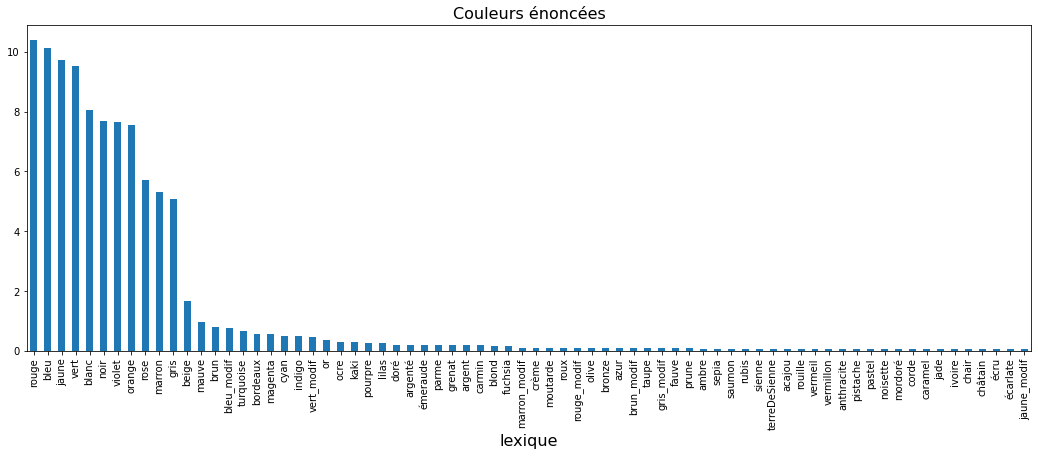

In [18]:
# visualisation de percent
print(vizu_bar(dfColor))

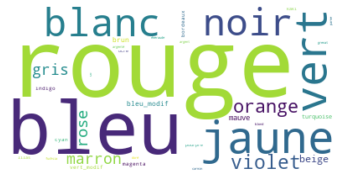

In [19]:
print(vizu_cloud(dfColor))

# POUR 2 COULEURS DONNEES :

Considérons 2 couleurs, quels sont les pénalistes à avoir cité ou non ce couleurs ?

Il est donc possible de modifier les couleurs de l'objet "myListTermes" pour observer un autre binôme.

Notre but initial : comparer 'brun' et 'marron'


In [20]:
# pour l'instant, uniquement une liste de 2 termes!
# myListTermes=["rouge","rose"]
myListTermes=["brun","marron"]

In [21]:
for i, l in dfColor.iterrows():
    for color in myListTermes:
        if l["lexique"]==color:
            print(l)

lexique    marron
number        105
percent      5.32
Name: 44, dtype: object
lexique    brun
number       16
percent    0.81
Name: 14, dtype: object


Questionnaire : "Écrivez une liste de choses (êtres, objets,...) qu'on pourrait décrire proprement comme étant MARRON / BRUN:"

Quels sont les panélistes qui ont cité brun et/ou marron ?

In [22]:
print("\npanélistes qui ont cité les 2 :")
print(findPanelistes(myListTermes,myColColor)[0])

print("\npanélistes qui n'ont cité que le " + myListTermes[0])
print(findPanelistes(myListTermes,myColColor)[1])

print("\npanélistes qui n'ont cité que le " + myListTermes[1])
print(findPanelistes(myListTermes,myColColor)[2])


panélistes qui ont cité les 2 :
[417, 496, 277, 406, 474]

panélistes qui n'ont cité que le brun
[497, 284, 77, 133]

panélistes qui n'ont cité que le marron
[384, 259, 135, 136, 394, 140, 141, 278, 150, 409, 410, 283, 414, 415, 422, 169, 298, 426, 428, 430, 175, 306, 440, 312, 316, 325, 333, 79, 216, 218, 347, 475, 222, 354, 99, 357, 487, 361, 363, 495, 368, 370, 242, 367, 373, 115, 116]


# Ordre d'apparition des 2 couleurs choisies

In [23]:
# Selon la liste de termes choisis -> compter le nbr d'occ de chacun de ces termes
cptTotal=dict()
#listCommune = findPanelistes(myListTermes,myColColor)[0]

for t in range(0,len(myListTermes)):
    cptTotal[myListTermes[t]]=len(findPanelistes(myListTermes,myColColor)[0])+len(findPanelistes(myListTermes,myColColor)[t+1])

print("nb d'occ de chacune des couleurs :" + str(cptTotal))

nb d'occ de chacune des couleurs :{'brun': 9, 'marron': 52}


Dans quelle colonne du tableau la couleur est-elle mentionnée ?
Autrement dit dans quel ordre les couleurs viennent à l'esprit  des panélistes ?

In [24]:
myDicOrdreColor = dict()

for colColor in myColColor:
    for term in myListTermes:
        # si le term est dans la ligne
        if data.index[data[colColor] == term].tolist():
            myRangColor=int(re.sub("^.+x0?","",colColor))
            myRangNbAbs=len(data.index[dataColors[colColor] == term].tolist())
            
            myRangNbRel = round(myRangNbAbs*100/cptTotal[term],2)
            
            myDuo=(myRangNbAbs,myRangNbRel)
        
            if term in myDicOrdreColor:
                if myRangColor in myDicOrdreColor[term]:
                    myDicOrdreColor[term][myRangColor].append(myDuo)
                else:
                    myDicOrdreColor[term][myRangColor]=myDuo
            else:
                myDicOrdreColor[term]=dict()
                myDicOrdreColor[term][myRangColor]=myDuo
                #myDicOrdreColor[term].append(myDuo)

# résultat = pour un terme donné :
# { term : { position/n Col: ( valAbs , valRel), ...}, ...}
print(myDicOrdreColor)

{'marron': {5: (3, 5.77), 6: (11, 21.15), 7: (12, 23.08), 8: (9, 17.31), 9: (5, 9.62), 10: (5, 9.62), 11: (2, 3.85), 12: (1, 1.92), 13: (2, 3.85), 14: (1, 1.92), 19: (1, 1.92)}, 'brun': {6: (2, 22.22), 7: (3, 33.33), 9: (1, 11.11), 14: (1, 11.11), 18: (1, 11.11), 22: (1, 11.11)}}


Visualiser cet ordre d'apparition

  couleur  pos5   pos6   pos7   pos8   pos9  pos10  pos11  pos12  pos13  \
0  marron  5.77  21.15  23.08  17.31   9.62   9.62   3.85   1.92   3.85   
1    brun  0.00  22.22  33.33   0.00  11.11   0.00   0.00   0.00   0.00   

   pos14  pos18  pos19  pos22  
0   1.92   0.00   1.92   0.00  
1  11.11  11.11   0.00  11.11  


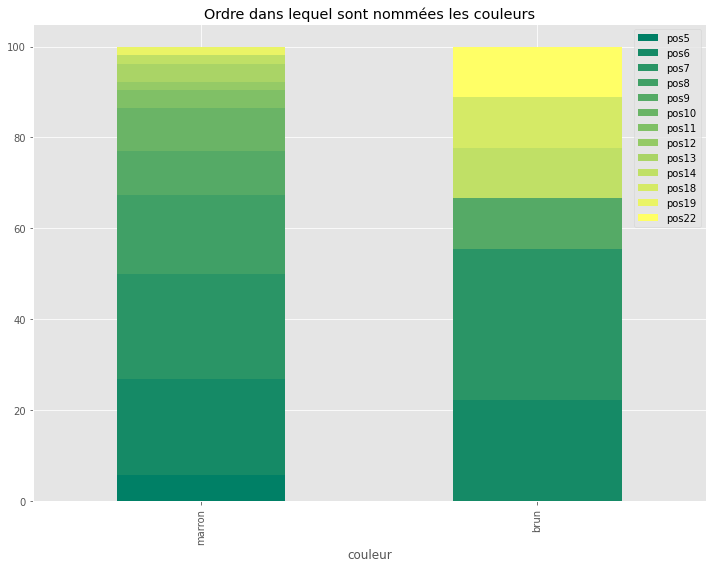

In [67]:
v = locals()
myVar = list()

# visulaser... les valeurs absolues : values[0] / les valeurs relatives : values[1]
for keyTerm in myDicOrdreColor:
    # créer la variable : color_mean = list() - ou color reprend chcune des couleurs choisies
    v[str(keyTerm)+str("_mean")] = [keyTerm,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    myVar.append(str(keyTerm)+str("_mean"))
    
    for pos, values in myDicOrdreColor[keyTerm].items():
        # VALEURS ABSOLUES
        # eval(keyTerm+str("_mean"))[pos] = values[0]
        # VALEURS RELATIVES
        eval(keyTerm+str("_mean"))[pos] = values[1]

columnsName=list()
columnsName.append('couleur')
for i in range(1,26):
    name='pos'+str(i)
    columnsName.append(name)
    
#print(columnsName)

# create data
df = pd.DataFrame([eval(str(myVar[0])), eval(str(myVar[1]))],
                  columns=columnsName)
# Ne garder que les positions occupées par les 2 couleurs (=> enlever si chacune est à 0)
df_NotNul=df.loc[:, (df != 0).any(axis=0)]
# view data
print(df_NotNul)

# dégradé de couleurs modifiable
# http://scipy.github.io/old-wiki/pages/Cookbook/Matplotlib/Show_colormaps
# colormap='Blues','RdBu','winter'
df_NotNul.plot(x='couleur', kind='bar', stacked=True, colormap='summer', figsize=(10,8),
        title='Ordre dans lequel sont nommées les couleurs')

plt.tight_layout()
plt.show()


# OBJETS MARRON

- Créer un sous-dataframe des colonnes concernées (colonnes LI01x01 à LI01x15)

In [26]:
myColObjMarron = lstCol('LI01x',16)

- lister et compter les objets marron :

In [27]:
print(lstLexique(myColObjMarron))

           lexique  number
0             bois      85
1            terre      65
2           marron      27
3             yeux      35
4        châtaigne      22
..             ...     ...
292  pomme pourrie       1
293         bottes       1
294        gateaux       1
295     hippocampe       1
296         plante       1

[297 rows x 2 columns]


Créer un fichier csv pour nettoyer le lexique

In [28]:
lstLexique(myColObjMarron).to_csv("objMarron.csv", sep = '\t', index = False)

In [29]:
# importer le csv de correction et regarder si l'import est ok
csvToDicNett("objMarron_nett.csv")

,lexique,number
0,ours,26
1,amande,1
2,animal,1
3,arbre,15
4,argile,1
...,...,...
152,valise,1
153,verre,1
154,vêtement,9
155,voiture,1


In [30]:
dfObjMarron=compteLexique(csvToDicNett("objMarron_nett.csv"))
print(dfObjMarron)

               lexique  number  percent
16                bois     100    10.18
57               terre      79     8.04
25            chocolat      67     6.82
59              marron      51     5.19
43           châtaigne      49     4.99
..                 ...     ...      ...
61   différents_objets       1     0.10
58      animaux_poilus       1     0.10
56               datte       1     0.10
55              cuivre       1     0.10
156              volet       1     0.10

[157 rows x 3 columns]


- visualisé ce qui est supérieur ou égal à 1%

AxesSubplot(0.125,0.125;0.775x0.755)


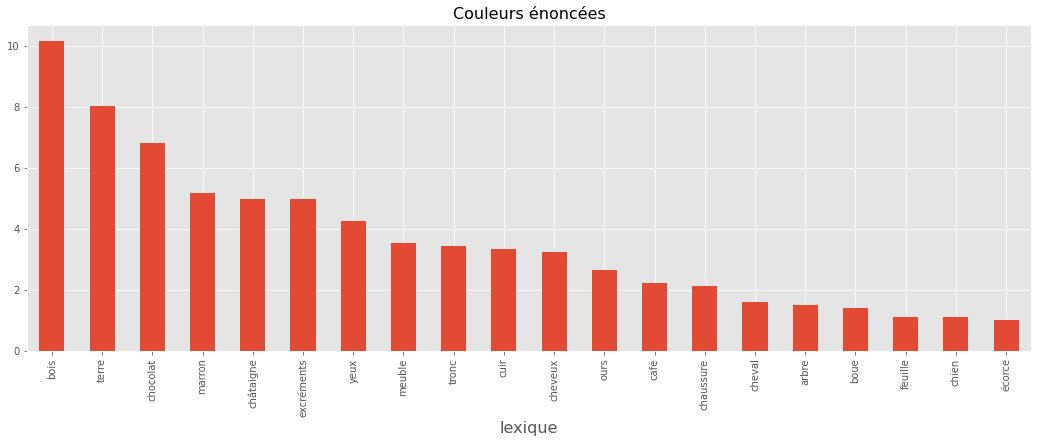

In [57]:
df_mask=dfObjMarron['percent']>=1
filtered_dfObjMarron=dfObjMarron[df_mask]
print(vizu_bar(filtered_dfObjMarron))

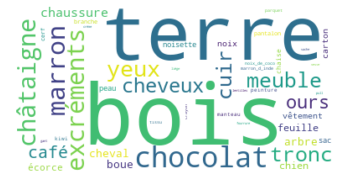

In [58]:
print(vizu_cloud(dfObjMarron))

# OBJETS BRUN

- Créer un sous-dataframe des colonnes concernées (colonnes LI02x01 à LI02x15)

In [60]:
myColObjBrun = lstCol('LI02x',16)

- regarder le lexique

In [61]:
print(lstLexique(myColObjBrun))

                       lexique  number
0                      cheveux     117
1                         ours      57
2                       cheveu       5
3                         yeux      33
4                         bois      15
..                         ...     ...
188              peau meurtrie       1
189                      lampe       1
190                 devantures       1
191                      vison       1
192  souches d'arbres pourries       1

[193 rows x 2 columns]


In [62]:
dfObjBrun=compteLexique(csvToDicNett("objBrun_nett.csv"))
print(dfObjBrun)

      lexique  number  percent
31    cheveux     136    24.46
48       ours      67    12.05
64       yeux      34     6.12
35       peau      23     4.14
9        bois      21     3.78
..        ...     ...      ...
55      fière       1     0.18
52   fasciste       1     0.18
51       idem       1     0.18
46   aliments       1     0.18
117     volet       1     0.18

[118 rows x 3 columns]


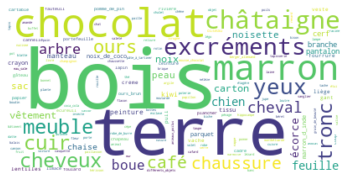

In [63]:
print(vizu_cloud(dfObjMarron))

- visualisé ce qui est supérieur ou égal à 1%

AxesSubplot(0.125,0.125;0.775x0.755)


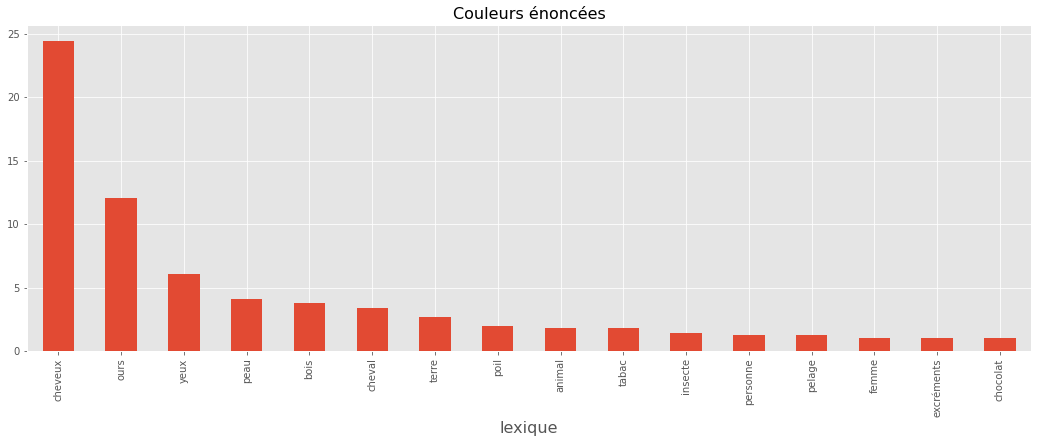

In [64]:
df_mask=dfObjBrun['percent']>=1
filtered_dfObjBrun=dfObjBrun[df_mask]
#print(filtered_dfObjBrun)
print(vizu_bar(filtered_dfObjBrun))

# PHRASES ACCEPTABLES ?

Questionnaire : "Est-ce que ces phrases sont acceptables dans la langue française courante ?"
    
A101_01 -> A101_05
...
A105_01 -> A105_05

Réponse -1 (pas acceptable) à 3 (tout à fait acceptable)

# DERIVES acceptables ou non

DE01_01 -> DE01_10

!!! _ et non x

Questionnaire : "Quels termes sont acceptables dans la langue française courante ?"


In [68]:
# import du fichier csv
csv_col="derives.csv"
# créer l'objet "data", contenant l'ensemble des données
derive = pd.read_csv(csv_col)
myNamesColonnes=derive['dérivé'].tolist()
print(myNamesColonnes)

['violacé', 'marronnasse', 'verdelet', 'marronâtre', 'rougeâtre', 'brunâtre', 'griselet', 'mauvasse', 'olivacé', 'bleuâtre']


In [69]:
myColDerives=lstCol('DE01_',11)
print(myColDerives)

#Créer un sous tableau ne contenant que ces colonnes
dataDerives = data.loc[:,myColDerives]
#mettre les bons titres :
dataDerives.columns = myNamesColonnes
print(dataDerives)


['DE01_01', 'DE01_02', 'DE01_03', 'DE01_04', 'DE01_05', 'DE01_06', 'DE01_07', 'DE01_08', 'DE01_09', 'DE01_10']
      violacé  marronnasse  verdelet  marronâtre  rougeâtre  brunâtre  \
CASE                                                                    
52        NaN          NaN       NaN         NaN        NaN       NaN   
54        1.0          3.0      -1.0         3.0        1.0       3.0   
55        1.0          2.0      -1.0         3.0        1.0       1.0   
61        2.0          2.0       2.0         2.0        1.0       1.0   
63        NaN          NaN       NaN         NaN        NaN       NaN   
...       ...          ...       ...         ...        ...       ...   
501       1.0          2.0       3.0         1.0        1.0       1.0   
504       NaN          NaN       NaN         NaN        NaN       NaN   
507       2.0          2.0       3.0         1.0        1.0       1.0   
509       NaN          NaN       NaN         NaN        NaN       NaN   
510       1.0

In [70]:
#df_pivot = dataDerives.pivot_table(values = 'Number', columns = 'Year', index = ['FirstName', 'Sex'])
# enlever les lignes où tout est "Na"
dataDerives=dataDerives.dropna(how = 'all')

myCptDerive=[dataDerives[c].value_counts().to_dict() for c in list(myNamesColonnes)]
#print(myCptDerive)

myDfAcceptabilite = pd.DataFrame.from_dict(myCptDerive)
#print(myDfAcceptabilite)
myDfAcceptabilite=myDfAcceptabilite.transpose()
myDfAcceptabilite.columns = myNamesColonnes
myDfAcceptabilite=myDfAcceptabilite.transpose()
print(myDfAcceptabilite)

               1.0   2.0  -1.0    3.0   0.0
violacé       93.0  47.0   9.0    8.0   1.0
marronnasse   32.0  41.0  18.0   66.0   1.0
verdelet       4.0  43.0  41.0   69.0   1.0
marronâtre    33.0  60.0  12.0   53.0   NaN
rougeâtre    139.0  13.0   4.0    1.0   1.0
brunâtre     113.0  30.0   8.0    7.0   NaN
griselet       8.0  33.0  47.0   69.0   1.0
mauvasse       1.0  20.0  25.0  111.0   1.0
olivacé       14.0  52.0  27.0   64.0   1.0
bleuâtre     103.0  34.0  11.0   10.0   NaN
